In [106]:
!pip install pandas numpy xgboost scikit-learn matplotlib

  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.3.0-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 3.7 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.1 MB 3.5 MB/s eta 0:00:02
   --------- ------------------------------ 1.8/8.1 MB 3.5 MB/s eta 0:00:02
   ------------ --------------------------- 2.6/8.1 MB 3.3 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.1 MB 3.4 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/8.1 MB 3.2 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 2.9 MB/s eta 0:00:02
   ------------------------ --------------- 5

In [141]:
import pandas as pd
import numpy as np
from datetime import timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

In [143]:
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv("AI Dataset.csv")


df.columns = df.columns.str.strip().str.lower()

df = df.drop_duplicates()

for col in ["date", "special_from_date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')  # Invalid dates -> NaT


numeric_cols = ["qty_ordered", "price", "special_price"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Invalid numbers -> NaN

for col in numeric_cols:
    if col in df.columns:
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)


if "special_from_date" in df.columns:
    df["special_from_date"] = df["special_from_date"].fillna(pd.Timestamp("2100-01-01"))

if "date" in df.columns:
    df = df.dropna(subset=["date"])

if "product_id" in df.columns:
    median_val=df["product_id"].median()
    df["product_id"] = df["product_id"].fillna(median_val)


df = df[df["qty_ordered"] >= 0]         # no negative sales
df = df[df["price"] > 0]              # no zero/negative prices
df = df[df["special_price"] >= 0]       # ensure non-negative


df = df.astype({
    "product_id": "int",
    "qty_ordered": "int",
    "price": "float64",
    "special_price": "float64"
})

print("\nData Cleaning Summary:")
print(df.info())
print("\nMissing Values per Column:")
print(df.isna().sum())



Data Cleaning Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 181170 entries, 0 to 182999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   product_id         181170 non-null  int64         
 1   date               181170 non-null  datetime64[ns]
 2   qty_ordered        181170 non-null  int64         
 3   price              181170 non-null  float64       
 4   special_price      181170 non-null  float64       
 5   special_from_date  181170 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 9.7 MB
None

Missing Values per Column:
product_id           0
date                 0
qty_ordered          0
price                0
special_price        0
special_from_date    0
dtype: int64


In [144]:
df.head()

,product_id,date,qty_ordered,price,special_price,special_from_date
0,1000,2020-02-23,0,40.80,31.95,2100-01-01
1,1001,2020-02-23,0,59.40,43.93,2020-11-24
2,1002,2020-02-23,0,17.80,14.27,2020-08-07
3,1003,2020-02-23,0,45.75,33.31,2018-02-01
4,1004,2020-02-23,0,18.40,16.05,2021-03-17


In [145]:
df = df.sort_values(["product_id", "date"])

In [146]:
def create_features(data):
    data = data.copy()
    
    #Time-based features
    data["day_of_week"] = data["date"].dt.dayofweek
    data["week_of_year"] = data["date"].dt.isocalendar().week.astype(int)
    data["month"] = data["date"].dt.month
    data["quarter"] = data["date"].dt.quarter
    data["is_weekend"] = data["day_of_week"].isin([5, 6]).astype(int)
    
    # Active discount flag
    data["special_active"] = (data["date"] >= data["special_from_date"]).astype(int)
    
    #  Group by product for lag/rolling 
    group = data.groupby("product_id", group_keys=False)
    
    # Lag & rolling features
    data["lag_1"] = group["qty_ordered"].shift(1)
    data["lag_7"] = group["qty_ordered"].shift(7)
    data["lag_14"] = group["qty_ordered"].shift(14)
    data["lag_28"] = group["qty_ordered"].shift(28)

    data["rolling_avg_7"]  = group["qty_ordered"].shift(1).rolling(window=7).mean()
    data["rolling_avg_28"] = group["qty_ordered"].shift(1).rolling(window=28).mean()
    
    # Price difference 
    data["price_diff"] = data["price"] - data["special_price"]

    # Discount percentage
    data["discount_pct"] = np.where(data["price"] > 0, (data["price"] - data["special_price"]) / data["price"], 0)

    # Price change trend ---
    data["price_change_trend"] = group["price"].diff(1)  # daily price delta

    # Price elasticity proxy 
    
    data["price_pct_change"] = group["price"].pct_change()

    # Seasonality indicators 
    # data["sin_week"] = np.sin(2 * np.pi * data["week_of_year"] / 52)
    # data["cos_week"] = np.cos(2 * np.pi * data["week_of_year"] / 52)
    
    return data


df = create_features(df).dropna()

In [147]:
df.head()

,product_id,date,qty_ordered,price,special_price,special_from_date,day_of_week,week_of_year,month,quarter,...,lag_1,lag_7,lag_14,lag_28,rolling_avg_7,rolling_avg_28,price_diff,discount_pct,price_change_trend,price_pct_change
2800,1000,2020-03-22,0,40.8,31.95,2100-01-01,6,12,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,8.85,0.216912,0.0,0.0
2900,1000,2020-03-23,0,40.8,31.95,2100-01-01,0,13,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,8.85,0.216912,0.0,0.0
3000,1000,2020-03-24,0,40.8,31.95,2100-01-01,1,13,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,8.85,0.216912,0.0,0.0
3100,1000,2020-03-25,0,40.8,31.95,2100-01-01,2,13,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,8.85,0.216912,0.0,0.0
3200,1000,2020-03-26,0,40.8,31.95,2100-01-01,3,13,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,8.85,0.216912,0.0,0.0


In [148]:
from datetime import timedelta

cutoff_date = df["date"].max() - timedelta(weeks=8)
train_df = df[df["date"] < cutoff_date]
test_df  = df[df["date"] >= cutoff_date]

features = [
    "price", "special_price", "price_diff", "special_active","discount_pct","price_change_trend","price_pct_change",
    "day_of_week", "week_of_year", "month", "is_weekend",
    "lag_1", "lag_7", "lag_14", "lag_28",
    "rolling_avg_7", "rolling_avg_28",
]

X_train, y_train = train_df[features], train_df["qty_ordered"]
X_test,  y_test  = test_df[features],  test_df["qty_ordered"]

In [149]:
model = XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=3000,
                           objective='reg:linear',
                           max_depth=6,
                           learning_rate=0.01,
                           min_child_weight=1,
                           subsample=0.8,
                           colsample_bytree=0.8,
                           gamma=0,
                           reg_alpha=0,
                           reg_lambda=1)

model.fit(X_train, y_train)

C:\Users\jeeva\OneDrive\Desktop\XGB_for_product_pred\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:07:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [150]:
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"Validation MAE: {mae:.2f}")

non_zero_mask = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_mask] - preds[non_zero_mask]) / (y_test[non_zero_mask]))) * 100
print(f"MAPE: {mape:.2f}%")

rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE:", rmse)

Validation MAE: 1.26
MAPE: 61.24%
RMSE: 3.1552200903200673


In [151]:
non_zero_mask = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_mask] - preds[non_zero_mask]) / (y_test[non_zero_mask]))) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 61.24%


In [152]:
rmse = np.sqrt(mean_squared_error(y_test,preds))
print(f"RMSE:{rmse:0.2f}")

RMSE:3.16


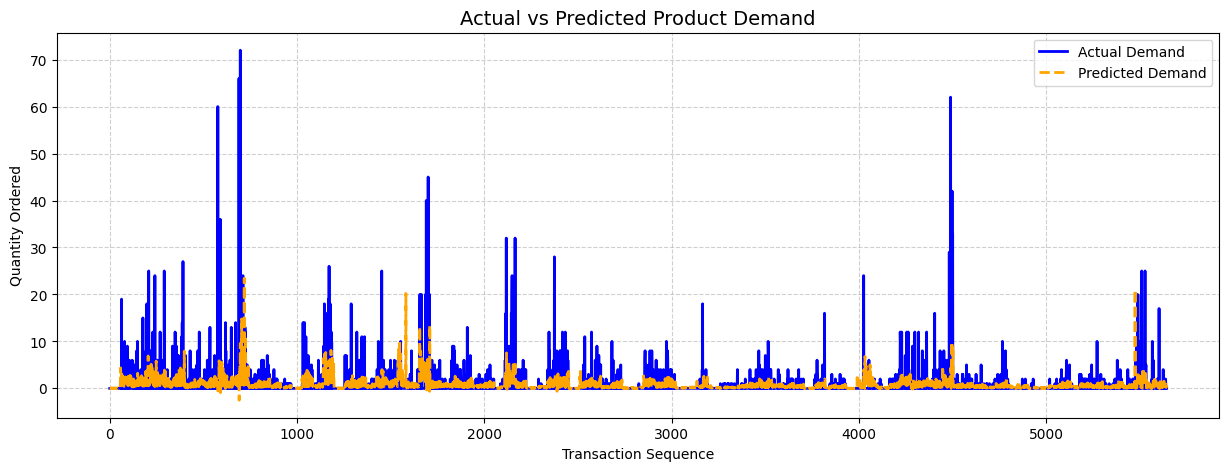

In [153]:
import matplotlib.pyplot as plt
import pandas as pd


y_test = pd.Series(y_test).reset_index(drop=True)
y_pred = pd.Series(preds).reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual Demand', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted Demand', color='orange', linestyle='--', linewidth=2)

plt.title('Actual vs Predicted Product Demand', fontsize=14)
plt.xlabel('Transaction Sequence')
plt.ylabel('Quantity Ordered')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [157]:
future_days = 56
last_date = df["date"].max()
future_dates = pd.date_range(last_date + timedelta(days=1), periods=future_days)

forecast = []

for pid in df["product_id"].unique():
    hist = df[df["product_id"] == pid].copy()
    
    for date in future_dates:
        new_row = {
            "product_id": pid,
            "date": date,
            "price": hist["price"].iloc[-1],
            "special_price": hist["special_price"].iloc[-1],
            "special_from_date": hist["special_from_date"].iloc[-1],
        }
        temp = pd.DataFrame([new_row])
        temp = create_features(pd.concat([hist, temp], ignore_index=True)).iloc[-1:]
        X_future = temp[features]
        pred=model.predict(X_future)[0]
        temp["predicted_qty"] = max(0, int(round(pred)))
        forecast.append(temp[["product_id", "date","price","predicted_qty"]])
        hist = pd.concat([hist, temp], ignore_index=True)

forecast_df = pd.concat(forecast).reset_index(drop=True)
print("8-Week Forecast:")
print(forecast_df.head(15))


8-Week Forecast:
    product_id       date  price  predicted_qty
0         1000 2025-02-26   40.8              0
1         1000 2025-02-27   40.8              6
2         1000 2025-02-28   40.8              2
3         1000 2025-03-01   40.8              1
4         1000 2025-03-02   40.8              1
5         1000 2025-03-03   40.8             59
6         1000 2025-03-04   40.8             44
7         1000 2025-03-05   40.8             16
8         1000 2025-03-06   40.8             15
9         1000 2025-03-07   40.8             11
10        1000 2025-03-08   40.8              9
11        1000 2025-03-09   40.8              9
12        1000 2025-03-10   40.8             60
13        1000 2025-03-11   40.8             45
14        1000 2025-03-12   40.8             32


In [156]:
forecast_df.to_csv("result_data.csv", index=False)